In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import umap
import os, sys
import random
import argparse
import torch
import scipy
from datetime import datetime
from sklearn.model_selection import train_test_split
from VAE_Functions import *
from VAE_Models import *

In [3]:
torch.manual_seed(2024)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device, torch.cuda.get_device_name())

cuda:0 NVIDIA A100 80GB PCIe


In [5]:
# X = np.load('data_Nuci,Nuc,Nsk,Mit,Gol,ER,Cel,Cyt_10000-max_ch-2_aug.npy')
# X = X[:, [0]]

X = np.load('data_Nuci,Nuc,Nsk,Mit,Gol,ER,Cel,Cyt_10000-max_ch-1_gauss-10_aug.npy')
print(X.shape, X.min(), X.max())

(281928, 1, 128, 128) 0.0 1.0


In [6]:
X_Shuffle = X.copy()
np.random.shuffle(X_Shuffle)
f1 = int(0.8*len(X_Shuffle))
f2 = int(0.9*len(X_Shuffle))
X_train = X_Shuffle[:f1]
X_val = X_Shuffle[f1:f2]
X_test = X_Shuffle[f2:]

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_val, dtype=torch.float32)

V = 'ResNet34_8-loc_gauss'
K = 256

C = X.shape[1]
save_path = V + '_lantent-' + str(K) + '_ch-' + str(C)

if not (os.path.isdir(save_path)):
    os.mkdir(save_path)

/tmp/ipykernel_4100920/4005998081.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_val, dtype=torch.float32)


In [7]:
B = 128
vae = VAE(ResNet_Encoder(num_Blocks=[3, 4, 6, 3], z_dim=K, channels=C),
          ResNet_Decoder(num_Blocks=[3, 4, 6, 3], z_dim=K, channels=C))
vae.to(device)

VAE(
  (encoder): ResNet_Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): resnet_encoder_block(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): resnet_encoder_block(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

In [8]:
checkpoint = 0
# vae.load_state_dict(torch.load('ResNet18_8-loc_ch-1_K-16_Ch-1/VAE_ResNet18_8-loc_ch-1_16.pt'))

train_losses, validation_losses = train_vae(vae, X_train, X_val, epochs=30, batch_size=B, lr=1e-4)

torch.save(vae.state_dict(), os.path.join(save_path, 'VAE_' + str(V) + '_' + str(K) + '_checkpoint' + str(checkpoint) + '.pt'))
np.save(os.path.join(save_path, 'Training-loss_' + str(V) + '_' + str(K) + '_checkpoint' + str(checkpoint) + '.npy'), train_losses)
np.save(os.path.join(save_path, 'Validation-loss_' + str(V) + '_' + str(K) + '_checkpoint' + str(checkpoint) + '.npy'), validation_losses)

print('done')

100%|██████████| 30/30 [2:59:21<00:00, 358.70s/it]  


done


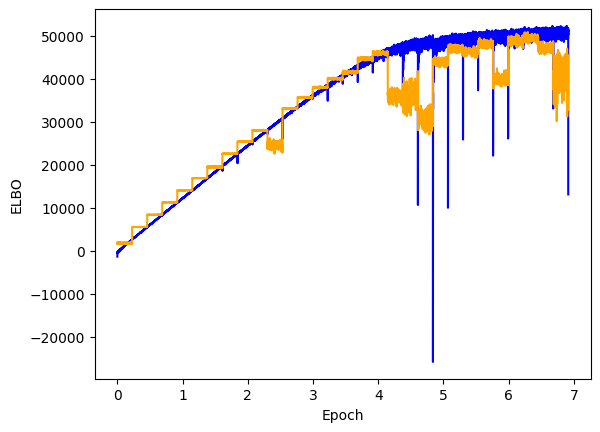

In [9]:
Plot_History(train_losses, validation_losses)
plt.show()

8it [00:00, 33.04it/s]


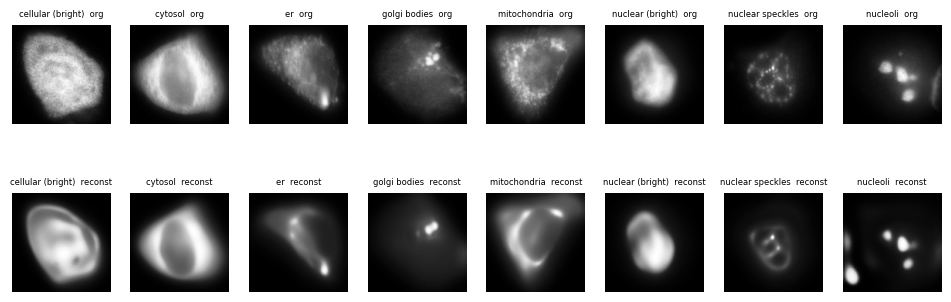

In [38]:
df = pd.read_csv('df_labels_Nuci,Nuc,Nsk,Mit,Gol,ER,Cel,Cyt_10000-max_ch-2_aug.csv')

    
labels = df['name'].to_numpy()
unq = np.unique(labels)

plt.figure(figsize=(12, 4), dpi=100)

for i, lbl in tqdm(enumerate(unq)):
    
    idx = np.where(labels == lbl)[0]
    
    im = torch.tensor(np.expand_dims(X[idx[0]], 0), dtype=torch.float).to(device)
    vae.eval()
    im_r, _ = vae.forward(im)

    plt.subplot(2, 8, i + 1)
    plt.title(lbl + '  org', fontsize=6)
    plt.imshow(im.cpu().detach()[0, 0], cmap='Greys_r')
    plt.axis('off')
    
    plt.subplot(2, 8, i + 9)
    plt.title(lbl + '  reconst', fontsize=6)
    plt.imshow(im_r.cpu().detach()[0, 0], cmap='Greys_r')
    plt.axis('off')

plt.savefig('Reconstruction_Plot.png')
plt.show()

In [11]:
Z = np.zeros([len(X), K])
vae.train()
for i in tqdm(np.arange(0, len(X), B)):
    
    btch = torch.tensor(X[i: i + B], dtype=torch.float32).to(device)
    _, z = vae.forward(btch)
    Z[i : i + B] = z.cpu().detach().numpy()

100%|██████████| 2203/2203 [02:23<00:00, 15.33it/s]


In [12]:
E = umap.UMAP(random_state=0).fit_transform(Z)
print(E.shape)

(281928, 2)


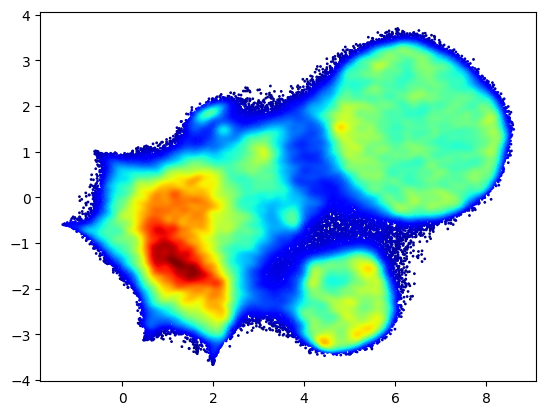

In [13]:
plot_2D_hist(E[:, 0], E[:, 1], colormap='jet', style='smooth')
plt.show()

8it [00:00, 157.97it/s]


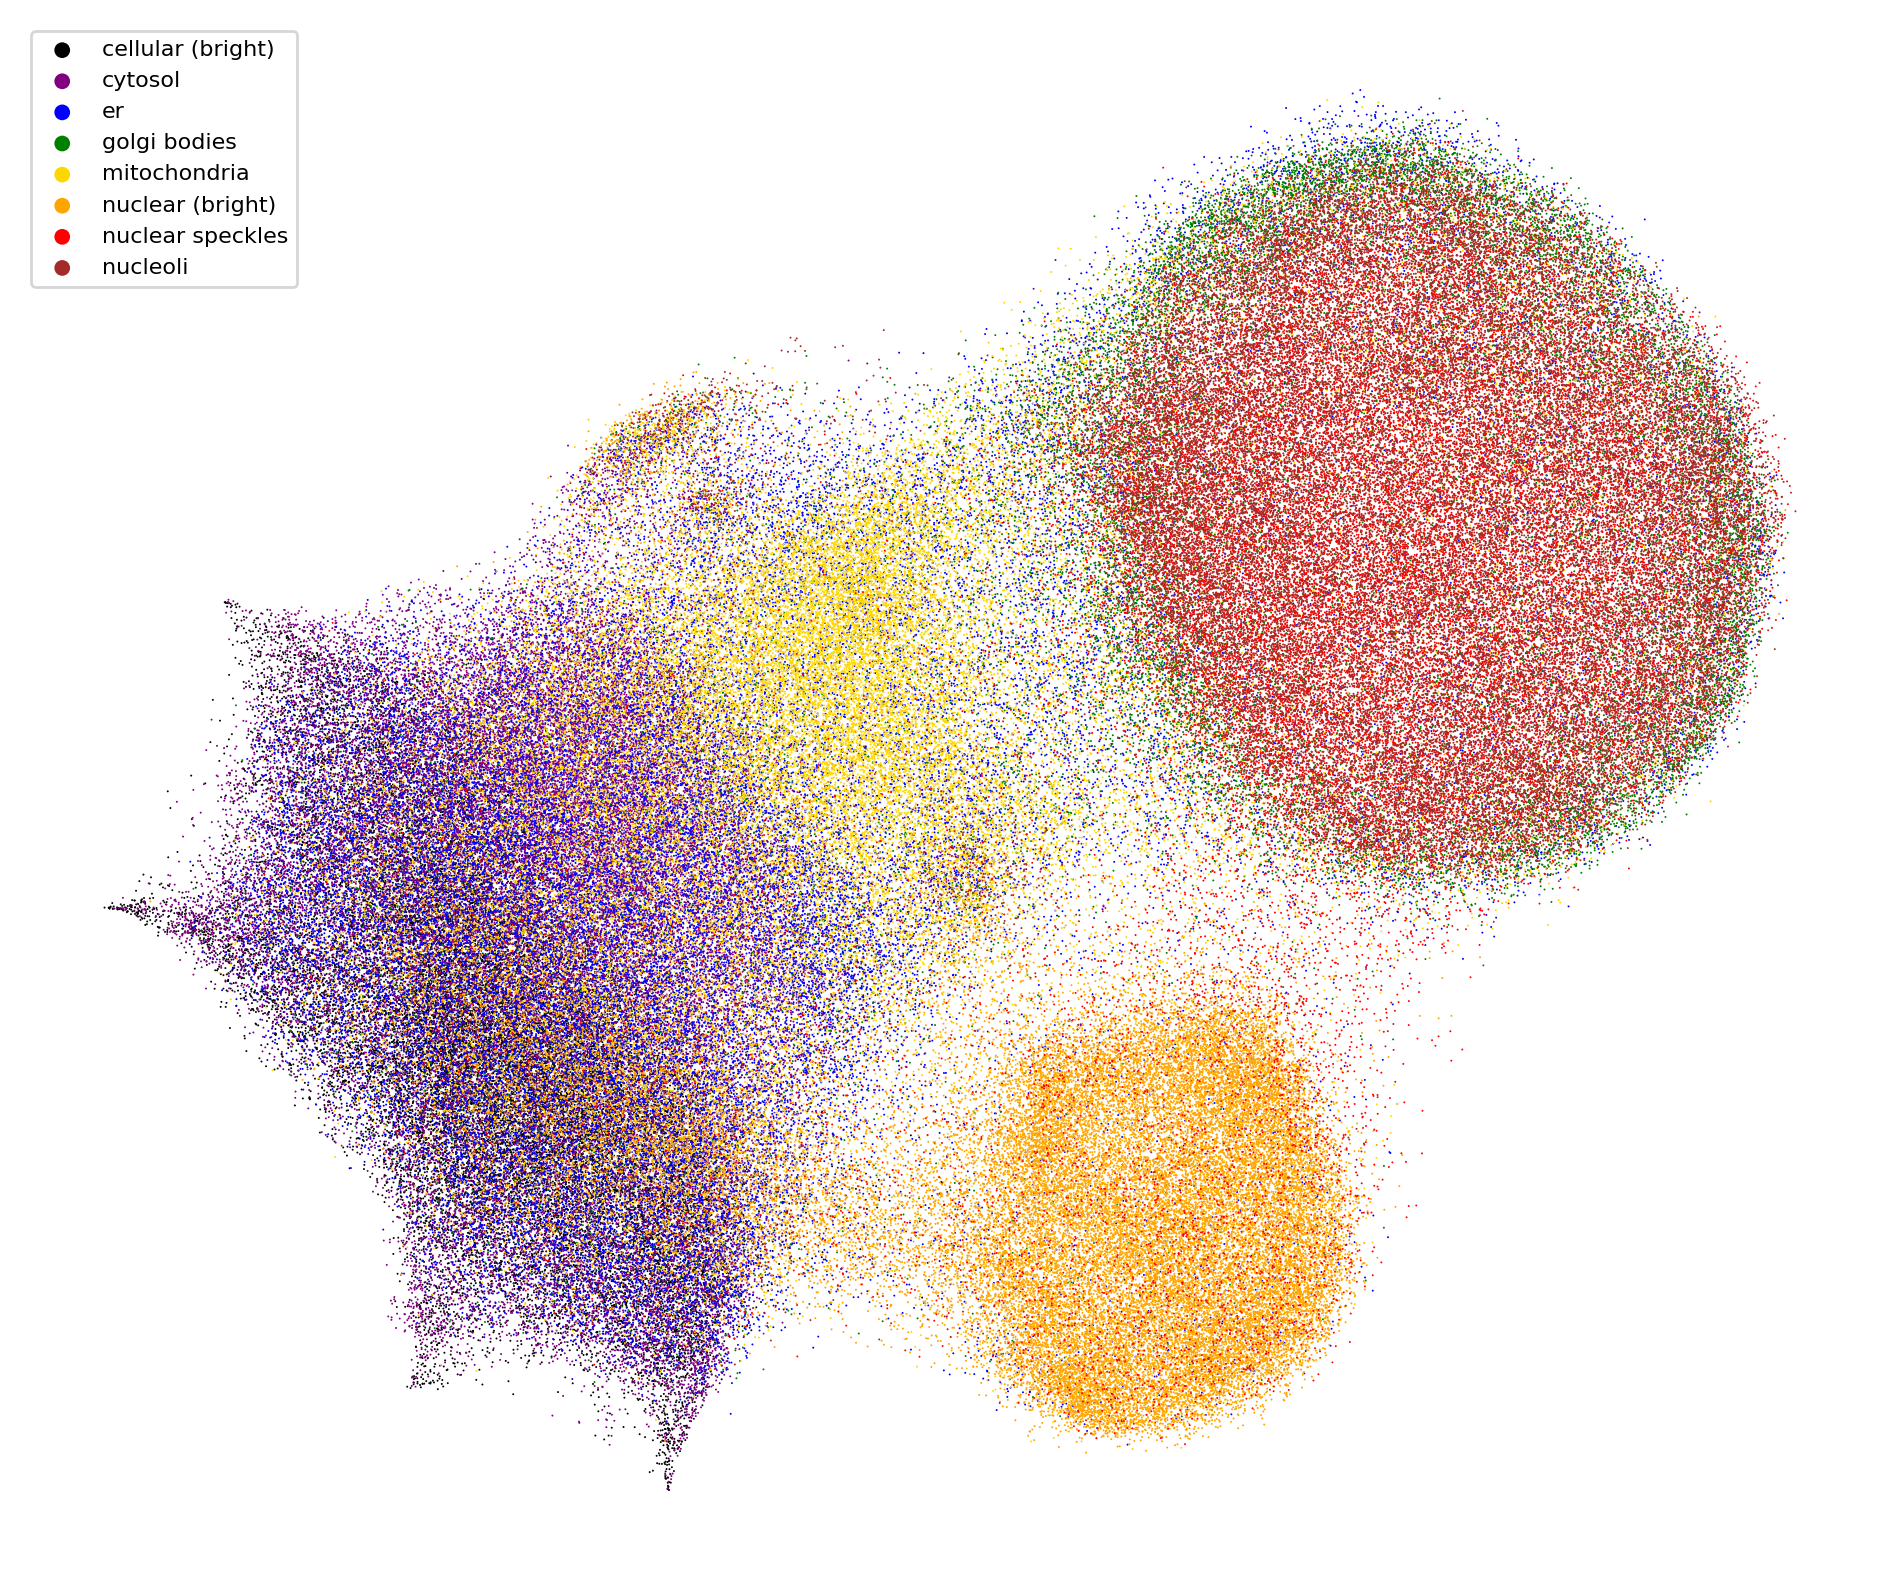

In [29]:
df = pd.read_csv('df_labels_Nuci,Nuc,Nsk,Mit,Gol,ER,Cel,Cyt_10000-max_ch-2_aug.csv')
labels = df['name'].to_numpy()
unq = np.unique(labels)
# color_list = Cycle_Colors(len(unq))
color_list = ['black', 'purple', 'blue', 'green', 'gold', 'orange', 'red', 'brown']

plt.figure(figsize=(12, 10), dpi=200)

plots = np.empty([len(unq)], dtype=object)
for i, lbl in tqdm(enumerate(unq)):
    idx = np.where(labels == lbl)
    plots[i] = plt.scatter(E[idx, 0], E[idx, 1], color=color_list[i], s=0.5, edgecolors='none')
    plt.axis('off')

plt.legend(plots, unq, fontsize=8, markerscale=8)
plt.savefig('Localization_UMAP.png')
plt.show()

8it [00:01,  6.64it/s]


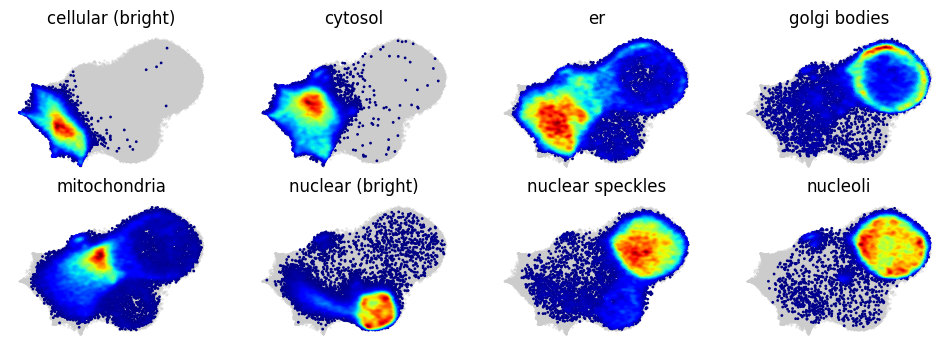

In [39]:
df = pd.read_csv('df_labels_Nuci,Nuc,Nsk,Mit,Gol,ER,Cel,Cyt_10000-max_ch-2_aug.csv')
labels = df['name'].to_numpy()
unq = np.unique(labels)
# color_list = Cycle_Colors(len(unq))
color_list = ['black', 'purple', 'blue', 'green', 'gold', 'orange', 'red', 'brown']

plt.figure(figsize=(12, 4), dpi=100)

for i, lbl in tqdm(enumerate(unq)):
    
    plt.subplot(2, 4,  i + 1)
    plt.title(lbl)
    
    plt.scatter(E[:, 0], E[:, 1], s=0.1, c='#CCCCCC')
    
    idx = np.where(labels == lbl)
    x_idx = np.squeeze(E[idx, 0])
    y_idx = np.squeeze(E[idx, 1])
    plot_2D_hist(x_idx, y_idx)
    
    plt.axis('off')

plt.savefig('Localization_Density_UMAP.png')
plt.show()